In [1]:
from scene import Scene
import taichi as ti
from taichi.math import *
import taichi.math as tm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import trimesh
import open3d as o3d

import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

%load_ext autoreload
%autoreload 2

matplotlib.use('Qt5Agg')
%matplotlib widget

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. Load model as voxel (e.g. Stanford bunny)

In [2]:
NUM_X, NUM_Y, NUM_Z = 128, 128, 128 #256, 256, 256 # 

def load_and_voxelize_mesh(file_path: str, voxel_size=0.005, num_x=NUM_X, num_y=NUM_Y, num_z=NUM_Z, need_rotate=False) -> np.ndarray:
    target_mesh = trimesh.load(file_path)
    assert isinstance(target_mesh, trimesh.Trimesh), "Loaded object should be a Trimesh"
    vertices = target_mesh.vertices
    faces = target_mesh.faces

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size)

    filled_voxels = np.zeros((num_x, num_y, num_z), dtype=np.uint8)
    for voxel in voxel_grid.get_voxels():
        voxel_coord = voxel.grid_index
        filled_voxels[voxel_coord[0], voxel_coord[1], voxel_coord[2]] = True
    for y in range(filled_voxels.shape[1]):
        slice_y = filled_voxels[:, y, :]
        filled_slice = ndimage.binary_fill_holes(slice_y)
        filled_voxels[:, y, :] = filled_slice

    if need_rotate:
        filled_voxels = np.transpose(filled_voxels, (0, 2, 1))  # Transpose from (x, y, z) to (x, z, y)
        filled_voxels = np.flip(filled_voxels, axis=2)  # Flip y-axis to make the object stand up

    print("Voxel shape:", filled_voxels.shape)  
    print("Number of filled voxels:", np.sum(filled_voxels))
    return filled_voxels

file_path = './assets/bun_zipper_res4.ply'
voxel_size = 0.004
bunny_voxels = load_and_voxelize_mesh(file_path, voxel_size)

file_path = "./assets/wine_glass.obj"
voxel_size = 0.07
glass_voxels = load_and_voxelize_mesh(file_path, voxel_size, need_rotate=True)

Voxel shape: (128, 128, 128)
Number of filled voxels: 13849
Voxel shape: (128, 128, 128)
Number of filled voxels: 9035


## 2. Preview scene using Path Tracing

In [3]:
GLASS_IOR = 1.5

@ti.func
def add_ball(r: ti.i32, origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    pad = 1
    for i, j, k in ti.ndrange((-r-pad, r+pad), (-r-pad, r+pad), (-r-pad, r+pad)):
        xyz = ivec3(i, j, k)
        if xyz.dot(xyz) < r**2: 
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func 
def add_bunny(origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange(NUM_X, NUM_Y, NUM_Z):
        if bunny_field[i, j, k] == 1:
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func
def add_glass(origin: tm.vec3, color: tm.vec3, mat: ti.i8):
    for i, j, k in ti.ndrange(NUM_X, NUM_Y, NUM_Z):
        if glass_field[i, j, k] == 1:
            scene.set_voxel(vec3(i, j, k) + origin, mat, color, ior=GLASS_IOR)

@ti.func
def origin_y(largest: int, r: int):
    return -(largest-r)-1

# Material LAMBERTIAN = 1 ; Material LIGHT = 2
@ti.kernel
def initialize_voxels():
    add_ball(LARGE_R, vec3(-32, origin_y(LARGE_R, LARGE_R), 0), RED, 1)
    add_ball(MEDIUM_R, vec3(-8, origin_y(LARGE_R, MEDIUM_R), 36), BLUE, 1)
    # add_ball(SMALL_R, vec3(47, -18, 37), WHITE, 1)
    # add_bunny(vec3(3, -18, 0), GREY, 1)
    # add_glass(vec3(3, -18, 0), WHITE, 1)
    
def floor_ratio(largest: int) -> float:
    return -1 / 64 * (largest)

LARGE_R, MEDIUM_R, SMALL_R = 24, 18, 6

BLACK, WHITE, YELLOW, PINK, GREY = vec3(0, 0, 0), vec3(1, 1, 1), vec3(1,1,0), vec3(1,0.5,0.8), vec3(0.7, 0.7, 0.7)
RED, BLUE, PURPLE, AZURE = vec3(0.9, 0, 0.1), vec3(0, 0.5, 1), vec3(0.2, 0.2, 0.6), vec3(0.4, 0.7, 1)

torch.cuda.empty_cache()
scene = Scene(exposure=1)

bunny_field = ti.field(dtype=ti.u8, shape=(NUM_X, NUM_Y, NUM_Z))
bunny_field.from_numpy(bunny_voxels)

glass_field = ti.field(dtype=ti.u8, shape=(NUM_X, NUM_Y, NUM_Z))
glass_field.from_numpy(glass_voxels)

scene.set_directional_light((0, 1, 0), 0.2, (1, 1, 1))
scene.set_background_color((1, 0.9, 0.9))

FLOOR_RATIO = floor_ratio(LARGE_R)
print("Floor Ratio:", FLOOR_RATIO)
scene.set_floor(height=FLOOR_RATIO, color=AZURE)
initialize_voxels()
scene.finish()

[Taichi] Starting on arch=cuda

Camera:
* Drag with your left mouse button to rotate
* Press W/A/S/D/Q/E to move

Floor Ratio: -0.375


## 3. View scene's IOR

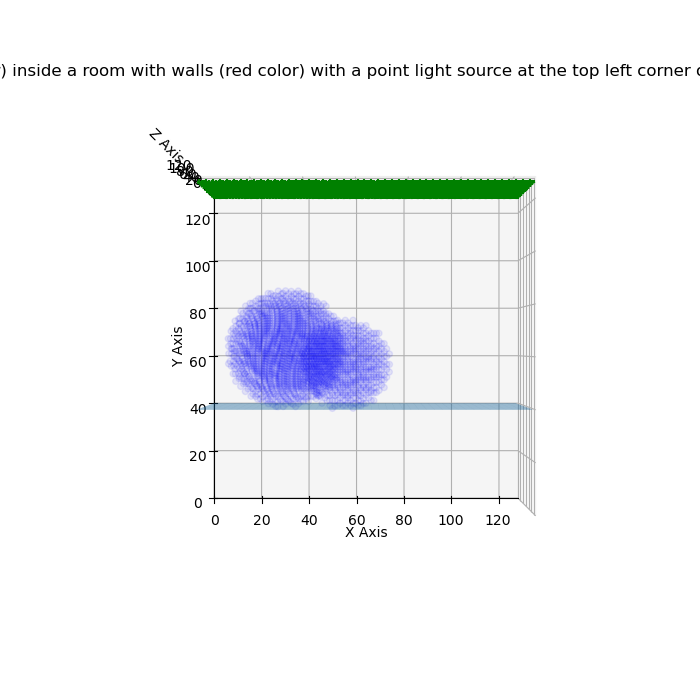

In [34]:
scene_ior = scene.get_ior_grid().to_numpy()
assert isinstance(scene_ior, np.ndarray) and scene_ior.shape == (NUM_X, NUM_Y, NUM_Z), "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 5
initial_wavefront_pos = np.array([(x / sampler_multiplier, NUM_Y - 1, z / sampler_multiplier) for x in range(NUM_X * sampler_multiplier) for z in range(NUM_Z * sampler_multiplier)])
initial_wavefront_dir = np.array([(0, -1, 0) for _ in range(NUM_X * NUM_Z * (sampler_multiplier**2))])

def floor_height() -> int:
    return int((1+FLOOR_RATIO) * NUM_Y / 2)

def plot_floor() -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    xx, zz = np.meshgrid(np.arange(NUM_X), np.arange(NUM_Z))
    yy = np.ones_like(xx) * floor_height()
    return xx, yy, zz

def show_ior_field(ior_field: np.ndarray, initial_wavefront_positions: np.ndarray, initial_wavefront_directions: np.ndarray, num_shown_points=2000):    
    plt.close("all") # clear previous plot

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, ior_field.shape[0])
    ax.set_ylim(0, ior_field.shape[1])
    ax.set_zlim(0, ior_field.shape[2])
    ax.set_title("Glass Sphere (blue color) inside a room with walls (red color) with a point light source at the top left corner of the room (green arrows)")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    initial_pos_np = initial_wavefront_positions
    initial_dir_np = initial_wavefront_directions
    # Initial wavefront positions
    subsample_indices = np.arange(0, len(initial_pos_np), 13 * sampler_multiplier)
    ax.quiver(initial_pos_np[subsample_indices, 0], initial_pos_np[subsample_indices, 1], initial_pos_np[subsample_indices, 2],
                initial_dir_np[subsample_indices, 0], initial_dir_np[subsample_indices, 1], initial_dir_np[subsample_indices, 2],
                color='green', length=1)

    # Regular sampling for the sphere
    x_points_sphere, y_points_sphere, z_points_sphere = np.where(ior_field == GLASS_IOR)
    subsample_step_sphere = max(1, len(x_points_sphere) // num_shown_points)  # Adjust the number to control the number of points
    subsample_indices_sphere = np.arange(0, len(x_points_sphere), subsample_step_sphere)

    ax.scatter(x_points_sphere[subsample_indices_sphere], y_points_sphere[subsample_indices_sphere], z_points_sphere[subsample_indices_sphere], color='blue', alpha=0.08)
    ax.view_init(elev=90, azim=-90)
    ax.plot_surface(*plot_floor(), alpha=0.5)
    plt.show()

show_ior_field(scene_ior, initial_wavefront_pos, initial_wavefront_dir)

## 4. Light simulator and compute irradiance

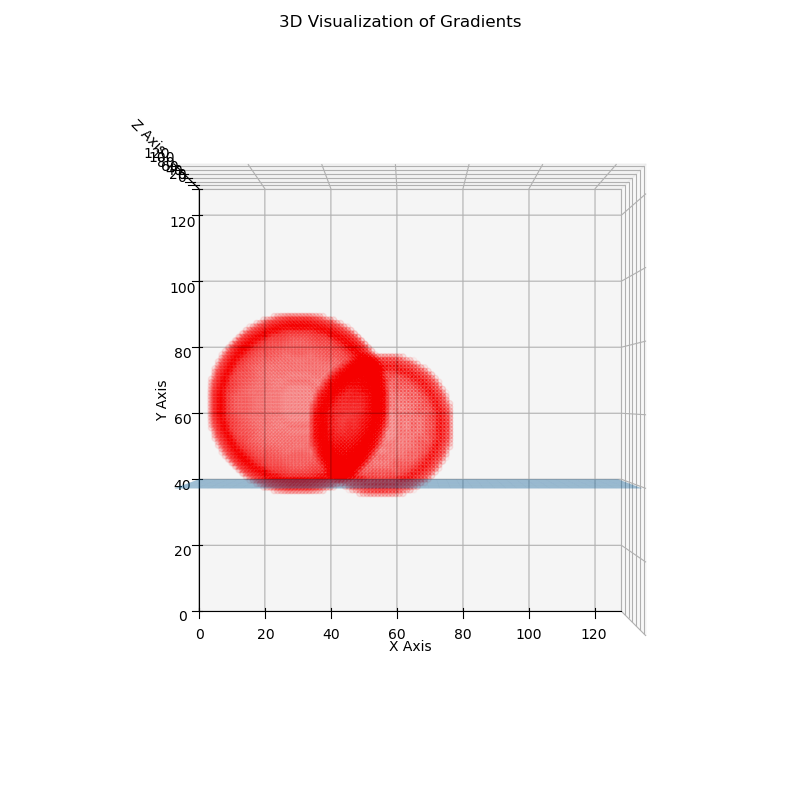

In [35]:
def compute_3d_gradients(ior_field: np.ndarray, sigma: float = 4.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Apply Gaussian filter to smooth the 3D voxels
    smoothed_field = gaussian_filter(ior_field, sigma=sigma, radius=1)
    grad_x, grad_y, grad_z = np.gradient(smoothed_field)
    return grad_x, grad_y, grad_z

def visualize_gradients_3d(grad_xyz: tuple[np.ndarray, np.ndarray, np.ndarray], threshold: float = 0.1, alpha: float = 0.5):
    # Convert gradients to numpy arrays
    grad_x, grad_y, grad_z = grad_xyz

    # Create a figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, grad_x.shape[0])
    ax.set_ylim(0, grad_y.shape[1])
    ax.set_zlim(0, grad_z.shape[2])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')

    # Compute the magnitude of the gradients
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)

    # Find the indices where the gradient magnitude exceeds the threshold
    indices = np.where(grad_magnitude > threshold)

    # Plot the gradient points exceeding the threshold
    ax.scatter(indices[0], indices[1], indices[2], c='red', alpha=alpha)

    ax.set_title('3D Visualization of Gradients')

    # Adjust the aspect ratio of the plot
    # ax.set_box_aspect((np.ptp(indices[0]), np.ptp(indices[1]), np.ptp(indices[2])))
    ax.view_init(elev=90, azim=-90)
    ax.plot_surface(*plot_floor(), alpha=0.5)
    plt.tight_layout()
    plt.show()


scene_ior_gradients = compute_3d_gradients(scene_ior, sigma=4.0)
visualize_gradients_3d(scene_ior_gradients, threshold=0.01, alpha=0.01)

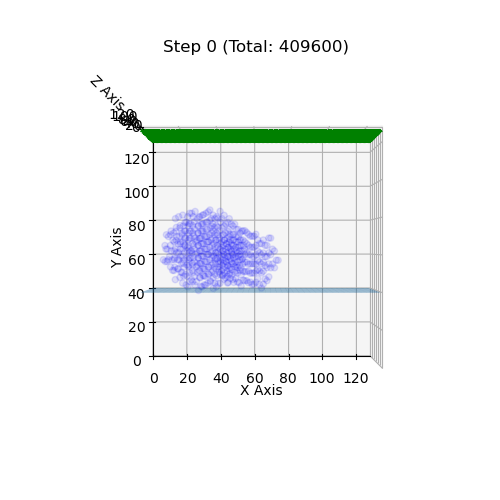

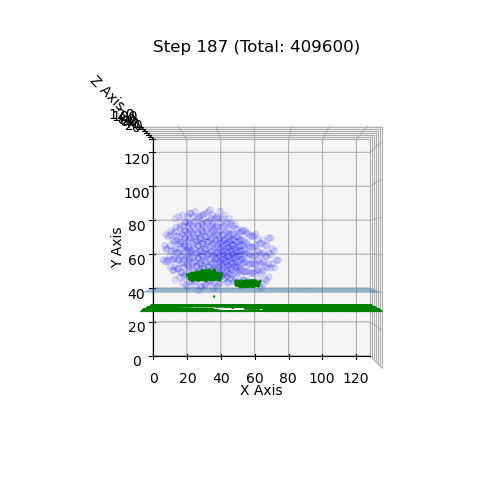

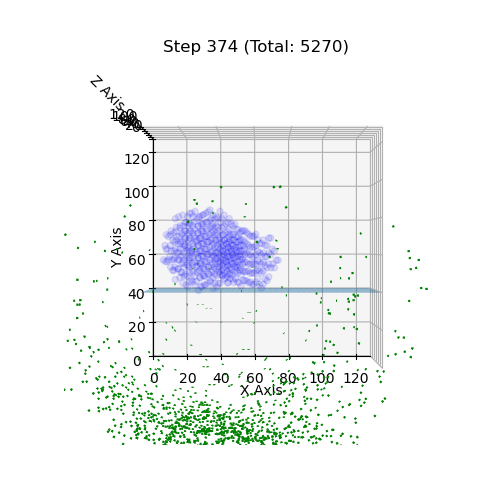

In [37]:
@torch.jit.script
def update_wavefront(pos: torch.Tensor, dir: torch.Tensor, within_mask: torch.Tensor, grad_xyz: tuple[torch.Tensor, torch.Tensor, torch.Tensor], IOR: torch.Tensor, delta_t: float) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    indices = pos.int()
    # Obtain the refractive index at the current position
    n = IOR[indices[:, 0].clamp(0, IOR.shape[0] - 1),
            indices[:, 1].clamp(0, IOR.shape[1] - 1),
            indices[:, 2].clamp(0, IOR.shape[2] - 1)]

    # Calculate the new position and direction of the wavefront
    new_pos = pos + delta_t * dir / (n**2).unsqueeze(1)

    # Create a mask to identify the wavefront positions that are within the boundaries of the IOR field
    new_within_mask = (new_pos[:, 0] >= 0) & (new_pos[:, 0] < IOR.shape[0]) & \
                      (new_pos[:, 1] >= 0) & (new_pos[:, 1] < IOR.shape[1]) & \
                      (new_pos[:, 2] >= 0) & (new_pos[:, 2] < IOR.shape[2]) & \
                      within_mask
    
    # Clamp the indices to ensure they are within the valid range of grad_xyz
    clamped_indices_x = indices[:, 0].clamp(0, grad_xyz[0].shape[0] - 1)
    clamped_indices_y = indices[:, 1].clamp(0, grad_xyz[1].shape[1] - 1)
    clamped_indices_z = indices[:, 2].clamp(0, grad_xyz[2].shape[2] - 1)

    # Update the direction only for the wavefront positions within the IOR boundaries
    new_dir = torch.where(new_within_mask.unsqueeze(1),
                          dir + delta_t * torch.stack([grad_xyz[0][clamped_indices_x, clamped_indices_y, clamped_indices_z],
                                                       grad_xyz[1][clamped_indices_x, clamped_indices_y, clamped_indices_z],
                                                       grad_xyz[2][clamped_indices_x, clamped_indices_y, clamped_indices_z]], dim=1) / n.unsqueeze(1),
                          dir)
    return new_pos, new_dir, new_within_mask

def plot_wavefront_positions(pos: np.ndarray, dir: np.ndarray, ior_field: np.ndarray, title: str, num_shown_points: int = 500):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, ior_field.shape[0])
    ax.set_ylim(0, ior_field.shape[1])
    ax.set_zlim(0, ior_field.shape[2])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title(title)
    subsample_indices = np.arange(0, len(pos), 13 * sampler_multiplier)
    ax.quiver(pos[subsample_indices, 0], pos[subsample_indices, 1], pos[subsample_indices, 2],
                dir[subsample_indices, 0], dir[subsample_indices, 1], dir[subsample_indices, 2],
                color='green', length=1)

    x_points, y_points, z_points = np.where(ior_field == GLASS_IOR)
    subsample_num = max(1, len(x_points) // num_shown_points)
    subsample_indices= np.arange(0, len(x_points), subsample_num)
    ax.scatter(x_points[subsample_indices], y_points[subsample_indices], z_points[subsample_indices], color='blue', alpha=0.1)
    ax.view_init(elev=90, azim=-90)
    ax.plot_surface(*plot_floor(), alpha=0.5)
    plt.show()

def simulate_wavefront_propagation(ior_field: np.ndarray, grad_xyz: tuple[np.ndarray, np.ndarray, np.ndarray], 
                                   initial_wavefront_pos: np.ndarray, initial_wavefront_dir: np.ndarray, 
                                   device: torch.device, num_steps: int = 100, delta_t: float = 1.0, num_show_images: int = 3) -> np.ndarray:
        
    show_indices =  [i for i in range(0, num_steps+1, max(num_steps // (num_show_images-1), 1))] + [num_steps - 1] if num_show_images > 0 else []

    cur_pos = torch.tensor(initial_wavefront_pos, device=device)
    cur_dir = torch.tensor(initial_wavefront_dir, device=device)
    cur_mask = torch.ones(initial_wavefront_pos.shape[0], dtype=torch.bool, device=device)
    grad_x, grad_y, grad_z = grad_xyz
    grad_tensor = (
        torch.tensor(grad_x, device=device),
        torch.tensor(grad_y, device=device),
        torch.tensor(grad_z, device=device)
    )
    ior_tensor = torch.tensor(ior_field, device=device)

    irradiance_grid = torch.zeros(ior_field.shape, device=device)

    for cur_step in range(num_steps):
        new_positions, new_directions, new_mask = update_wavefront(cur_pos, cur_dir, cur_mask, grad_tensor, ior_tensor, delta_t)
        cur_pos = new_positions
        cur_dir = new_directions
        cur_mask = new_mask

        indices = cur_pos.int()[cur_mask]
        unique_indices, counts = torch.unique(indices, return_counts=True, dim=0)
        irradiance_grid[unique_indices[:, 0], unique_indices[:, 1], unique_indices[:, 2]] += counts.float()

        if num_show_images > 0 and cur_step in show_indices:
            plot_wavefront_positions(cur_pos.cpu().numpy(), cur_dir.cpu().numpy(), ior_field, f"Step {cur_step} (Total: {indices.shape[0]})")

    return irradiance_grid.cpu().numpy()
        
test_delta_t = 0.4 * (NUM_Y / 100)
test_num_steps = int(1.5 * (NUM_Y / test_delta_t))
irradiance_grid = simulate_wavefront_propagation(scene_ior, scene_ior_gradients, initial_wavefront_pos, initial_wavefront_dir, device, test_num_steps, test_delta_t)

## 5. Visualise irradiance

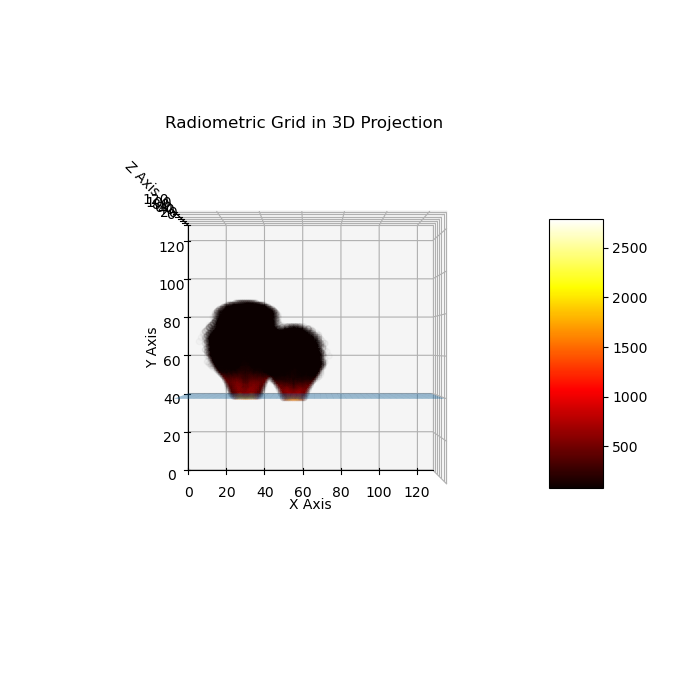

In [38]:
def remove_under_floor(irradiance_grid: np.ndarray, floor_height: int) -> np.ndarray:
    irradiance_grid[:, :floor_height, :] = 0
    return irradiance_grid

def visualise_irradiance_grid_3d(radiometric_grid: np.ndarray, threshold=3.0):
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlim(0, radiometric_grid.shape[0])
    ax.set_ylim(0, radiometric_grid.shape[1])
    ax.set_zlim(0, radiometric_grid.shape[2])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('Radiometric Grid in 3D Projection')
    ax.view_init(elev=90, azim=-90)
    ax.plot_surface(*plot_floor(), alpha=0.5)

    x_points, y_points, z_points = np.where(radiometric_grid > threshold)
    assert len(x_points) > 0, "No points found above the threshold value"
    # if only_above_floor:
    #     above_floor_indices = np.where(y_points > floor_height())
    #     radiometric_grid_filtered = radiometric_grid[x_points[above_floor_indices], y_points[above_floor_indices], z_points[above_floor_indices]]
    #     x_points = x_points[above_floor_indices]
    #     y_points = y_points[above_floor_indices]
    #     z_points = z_points[above_floor_indices]
    # else:
    radiometric_grid_filtered = radiometric_grid[x_points, y_points, z_points]

    ax.scatter(x_points, y_points, z_points, c=radiometric_grid_filtered, cmap='hot', alpha=0.02)    
    norm = Normalize(vmin=np.min(radiometric_grid_filtered), vmax=np.max(radiometric_grid_filtered)) # Normalize the colorbar
    mappable = ScalarMappable(norm=norm, cmap='hot')
    mappable.set_array(radiometric_grid_filtered)
    fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)  # Add colorbar
    plt.show()

above_floor_irradiance_grid = remove_under_floor(irradiance_grid, floor_height=floor_height())
visualise_irradiance_grid_3d(irradiance_grid, threshold=3*sampler_multiplier**2)

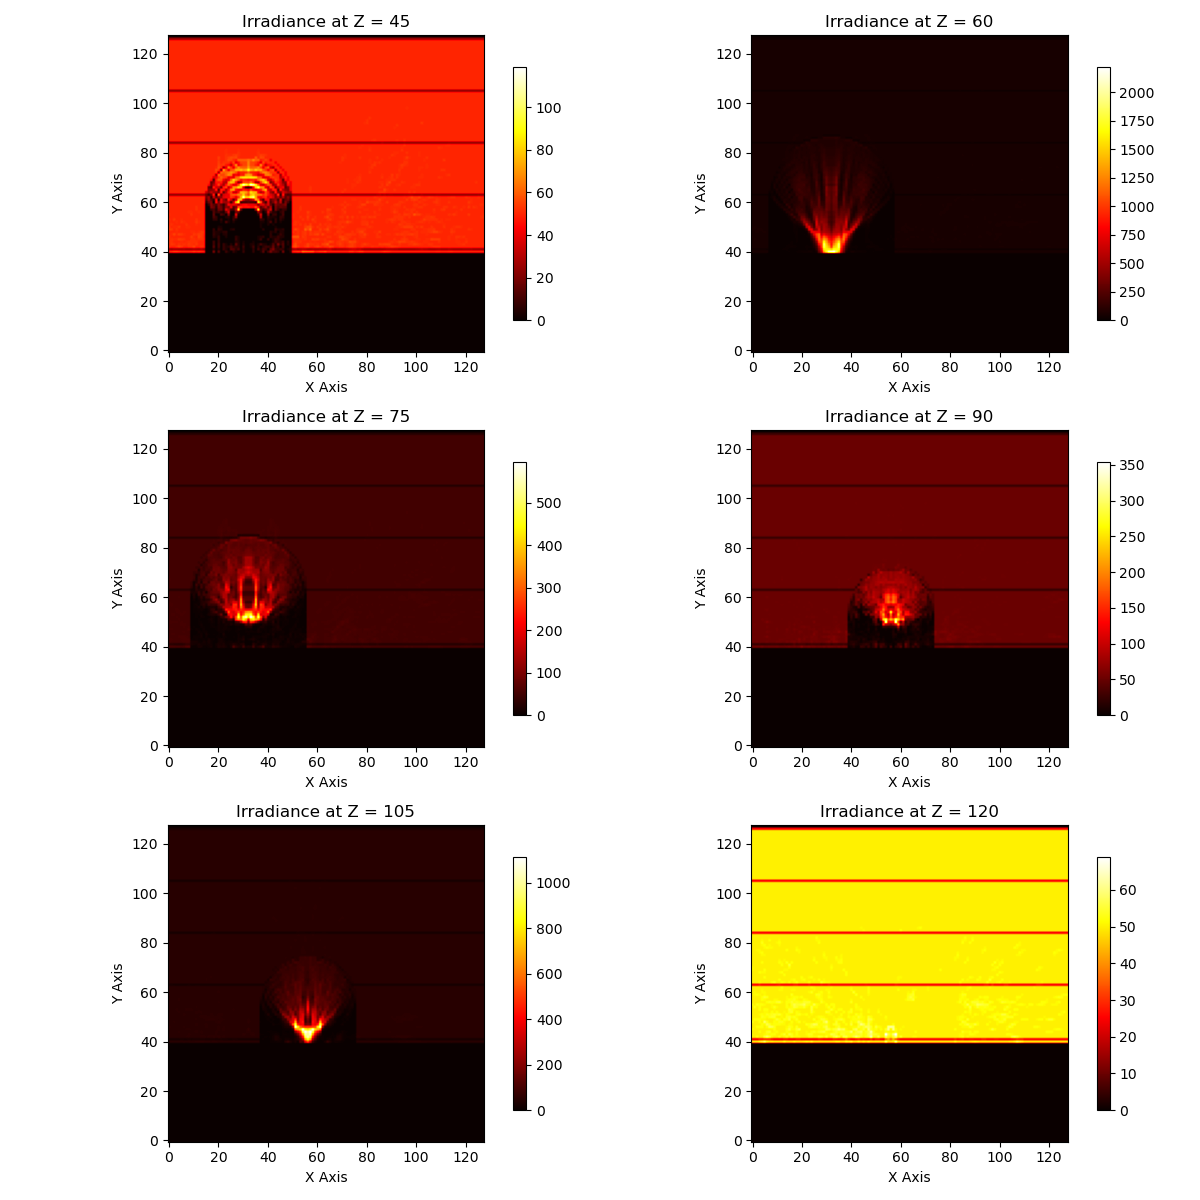

In [39]:
def visualise_irradiance_grid_slices(radiometric_grid: np.ndarray, threshold=3.0, num_slices=5, z_start=None, z_end=None):    
    if z_start is None:
        z_start = 0
    if z_end is None:
        z_end = radiometric_grid.shape[2] - 1
    
    z_indices = np.linspace(z_start, z_end, num_slices, dtype=int)
    num_rows = (num_slices + 1) // 2
    num_cols = 2    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()    
    for i, z_index in enumerate(z_indices):
        ax = axes[i]
        
        slice_data = radiometric_grid[:, :, z_index].T
        slice_data[slice_data < threshold] = 0
        
        im = ax.imshow(slice_data, cmap='hot', origin='lower')
        ax.set_title(f"Irradiance at Z = {z_index}")
        ax.set_xlabel("X Axis")
        ax.set_ylabel("Y Axis")
        
        fig.colorbar(im, ax=ax, shrink=0.8)
    
    for ax in axes[len(z_indices):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

above_floor_irradiance_grid = remove_under_floor(irradiance_grid, floor_height=floor_height())
visualise_irradiance_grid_slices(above_floor_irradiance_grid, threshold=3, num_slices=6, z_start=45, z_end=120)

## 6. Neural network irradiance （MLP）

In [9]:
# SEED = 42

# class IrradianceNet(nn.Module):
#     def __init__(self):
#         super(IrradianceNet, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(3, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1)
#         )
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)

#     def forward(self, x):
#         return self.model(x).squeeze()

# def prepare_data(irradiance: torch.Tensor, train_ratio=0.90) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
#     x = np.arange(irradiance.shape[0])
#     y = np.arange(irradiance.shape[1]) 
#     z = np.arange(irradiance.shape[2])
#     X, Y, Z = np.meshgrid(x, y, z)
#     inputs = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
#     targets = irradiance.flatten()

#     inputs = torch.from_numpy(inputs).float().to(device)
#     targets = targets.clone().detach().to(device)

#     # Random shuffle
#     # torch.manual_seed(SEED)
#     indices = torch.randperm(len(inputs))
#     inputs = inputs[indices]
#     targets = targets[indices]

#     # Split into training and validation sets
#     train_size = int(train_ratio * len(inputs))
#     train_inputs, val_inputs = inputs[:train_size], inputs[train_size:]
#     train_targets, val_targets = targets[:train_size], targets[train_size:]

#     return train_inputs, val_inputs, train_targets, val_targets

# def train_model(model: IrradianceNet, train_inputs: torch.Tensor, val_inputs: torch.Tensor, train_targets: torch.Tensor, val_targets: torch.Tensor, 
#                 num_epochs=320, batch_size=1024, patience=60):
#     torch.cuda.empty_cache()
    
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

#     best_val_loss = float('inf')
#     epochs_no_improve = 0
#     best_model = None

#     for epoch in range(num_epochs):
#         model.train()
#         for i in range(0, len(train_inputs), batch_size):
#             batch_inputs = train_inputs[i:i+batch_size]
#             batch_targets = train_targets[i:i+batch_size]
            
#             outputs = model(batch_inputs)
#             loss = criterion(outputs, batch_targets)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
#         model.eval()
#         with torch.no_grad():
#             val_outputs = model(val_inputs)
#             val_loss = criterion(val_outputs, val_targets)
        
#         if val_loss < best_val_loss * 0.95: # at least 5% improvement
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#             best_model = model.state_dict()
#             print(f"Current best model is at epoch {epoch + 1} and val loss: {val_loss.item():.4f}")
#         else:
#             epochs_no_improve += 1
        
#         if epochs_no_improve == patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break
        
#         if (epoch + 1) % 40 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

#     assert best_model is not None
#     model.load_state_dict(best_model)
#     torch.cuda.empty_cache()
#     return model

# def generate_irradiance_field_3d(model: IrradianceNet, size=100) -> torch.Tensor:
#     x = np.arange(size)
#     y = np.arange(size)
#     z = np.arange(size)
#     X, Y, Z = np.meshgrid(x, y, z)
#     coords = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)    
#     with torch.no_grad():
#         inputs = torch.tensor(coords, dtype=torch.float32, device=device)
#         predictions = model(inputs)
    
#     return predictions.reshape(size, size, size)

# # Prepare the data and train the MLP model
# train_inputs, val_inputs, train_targets, val_targets = prepare_data(irradiance_grid)
# model = IrradianceNet().to(device)  
# model = train_model(model, train_inputs, val_inputs, train_targets, val_targets)

# # Visualize the predicted irradiance field
# predicted_irradiance = generate_irradiance_field_3d(model)
# show_radiometric_grid_3d(predicted_irradiance, threshold=0.2, only_above_floor=True)

## 7. Octree

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import sys

class Node:
    def __init__(self, val: int = 0, children=None):
        self.val = val
        self.children = children or [None] * 8
    
    @property
    def is_leaf(self):
        return all(child is None for child in self.children)
    
    def __repr__(self):
        return self._repr_recursive()

    def _repr_recursive(self, depth=0, max_depth=2):
        indent = "  " * depth
        if self.is_leaf:
            return f"{indent}Node(val={self.val})"
        else:
            if depth >= max_depth:
                return f"{indent}Node(...)"
            children_repr = ",\n".join(self._repr_recursive_child(child, depth + 1, max_depth) for child in self.children)
            return f"{indent}Node(\n{children_repr})"

    def _repr_recursive_child(self, child, depth, max_depth):
        return "  " * depth + "None" if child is None else child._repr_recursive(depth, max_depth)

class OcTree:
    def __init__(self, threshold: int = 0):
        self.threshold = threshold
        self.grid_size = 0
        self.root = None
    
    def construct(self, grid: np.ndarray) -> None:
        self.root = self._build_tree(grid, 0, 0, 0, grid.shape[0])
        self.grid_size = grid.shape[0]
    
    def _build_tree(self, grid: np.ndarray, x: int, y: int, z: int, size: int) -> Node:
        if self._is_homogeneous(grid, x, y, z, size):
            return Node(grid[x, y, z])

        half_size = size // 2
        children = [
            self._build_tree(grid, x, y, z, half_size),
            self._build_tree(grid, x, y, z + half_size, half_size),
            self._build_tree(grid, x, y + half_size, z, half_size),
            self._build_tree(grid, x, y + half_size, z + half_size, half_size),
            self._build_tree(grid, x + half_size, y, z, half_size),
            self._build_tree(grid, x + half_size, y, z + half_size, half_size),
            self._build_tree(grid, x + half_size, y + half_size, z, half_size),
            self._build_tree(grid, x + half_size, y + half_size, z + half_size, half_size)
        ]
        
        if all(child.is_leaf for child in children):
            values = {child.val for child in children}
            if len(values) == 1:
                return Node(values.pop())
        
        return Node(children=children)
    
    def _is_homogeneous(self, grid: np.ndarray, x: int, y: int, z: int, size: int) -> bool:
        return np.ptp(grid[x:x+size, y:y+size, z:z+size]) <= self.threshold

    def query(self, x: int, y: int, z: int) -> int:
        return self._query(self.root, 0, 0, 0, self.grid_size, x, y, z)

    def _query(self, node: Node | None, x: int, y: int, z: int, size: int, qx: int, qy: int, qz: int) -> int:
        if node is None:
            raise ValueError("OcTree is empty. Maybe you forgot to construct it?")
        
        if node.is_leaf:
            return node.val

        half_size = size // 2
        octant = (
            (qx >= x + half_size) << 2 |
            (qy >= y + half_size) << 1 |
            (qz >= z + half_size)
        )
        
        return self._query(
            node.children[octant],
            x + (octant >> 2) * half_size,
            y + ((octant >> 1) & 1) * half_size,
            z + (octant & 1) * half_size,
            half_size,
            qx, qy, qz
        )
    
    def __len__(self):
        return self._count_nodes(self.root)

    def _count_nodes(self, node: Node | None) -> int:
        if node is None:
            return 0
        return 1 + sum(self._count_nodes(child) for child in node.children)
    
    def __sizeof__(self):
        return self._calculate_memory_usage(self.root)
    
    def _calculate_memory_usage(self, node: Node | None) -> int:
        if node is None:
            return 0
        return sys.getsizeof(node) + sum(self._calculate_memory_usage(child) for child in node.children)
    
    def visualize(self, figsize=(8, 8)):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        self._visualize_node(ax, self.root, 0, 0, 0, self.grid_size)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_zlim(0, self.grid_size)
        ax.view_init(elev=90, azim=-90)

        xx, yy, zz = plot_floor()
        ax.plot_surface(xx, yy, zz, alpha=0.5)
        plt.tight_layout()
        plt.title('Oct Tree Visualization')
        plt.show()
        
    def _visualize_node(self, ax, node: Node | None, x: float, y: float, z: float, size: float):
        if node is None:
            return
        if node.is_leaf:
            cube = np.array([
                [x, y, z],
                [x + size, y, z],
                [x + size, y + size, z],
                [x, y + size, z],
                [x, y, z + size],
                [x + size, y, z + size],
                [x + size, y + size, z + size],
                [x, y + size, z + size]
            ])
            ax.scatter(cube[:, 0], cube[:, 1], cube[:, 2], c='black', s=10)
            ax.text(x + size / 2, y + size / 2, z + size / 2, str(int(node.val)), ha='center', va='center')
        else:
            half_size = size / 2
            for i, child in enumerate(node.children):
                child_x = x + (i >> 2) * half_size
                child_y = y + ((i >> 1) & 1) * half_size
                child_z = z + (i & 1) * half_size
                self._visualize_node(ax, child, child_x, child_y, child_z, half_size)
    
octree = OcTree(threshold=10)
octree.construct(irradiance_grid)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {irradiance_grid.nbytes} bytes")
# octree.visualize()

Number of nodes: 13169
Octree Memory usage: 737464 bytes
In comparison, NumPy Storage Usage: 8388608 bytes


In [11]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

0.0

## Temp Tests

In [12]:
# x = ti.field(float, shape=(3, 3))
# a = np.arange(9).reshape(3, 3).astype(np.int32)
# x.from_numpy(a)
# print(x)
# type(x)
# arr = x.to_numpy()
# print(arr)
# type(arr)
# field = ti.Vector.field(3, int, shape=(256, 512))
# field.shape  # (256, 512)
# field.n      # 3

# array = field.to_numpy()
# array.shape  # (256, 512, 3)
# print(type(array))

# field.from_numpy(array)  # the input array must in the shape (256, 512, 3)
# print(type(field))

## *. Render